In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import backend as K
from keras import metrics
import tensorflow as tf

Using TensorFlow backend.
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yotam hermon\Anacond

In [2]:
train = pd.read_csv("./input/train.csv")

In [3]:
#Printing the size of the dataframe
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]))

Training dataset has 42000 observations and 785 variables


In [4]:
#Seperate the target and independant variables
df_x=train.iloc[:,1:]
df_y=train.iloc[:,0]

#Check the frequency of each number
df_y.value_counts().sort_index()

# Normalize the data
df_x = df_x / 255.0
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
df_x = df_x.values.reshape(-1,28,28,1)

# create an anomaly hold out group and then only train with the remaining digits
anom_mask = (df_y==9)
anomaly_test = df_x[anom_mask]
df_x = df_x[~anom_mask]
df_y = df_y[~anom_mask]
# make a test set the same size as the anomaly set
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=anomaly_test.shape[0], random_state=42)
print('Training Images', X_train.shape, 'Testing Images', X_test.shape, 'Anomaly Images', anomaly_test.shape)

Training Images (33624, 28, 28, 1) Testing Images (4188, 28, 28, 1) Anomaly Images (4188, 28, 28, 1)


In [5]:
#Seperate the target and independant variables
df_x1=train.iloc[:,1:]
df_y1=train.iloc[:,0]

#Check the frequency of each number
df_y1.value_counts().sort_index()

#Split the dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_x1, df_y1, test_size=0.2, random_state=0)
print(X_train1.shape)
print(X_test1.shape)

(33600, 784)
(8400, 784)


In [6]:
df_images = [X_train1,X_test1]
df_labels = [y_train1,y_test1]

result_images = pd.concat(df_images,ignore_index=True)
result_labels = pd.concat(df_labels,ignore_index=True)

In [7]:
batch_size = 256
original_shape = X_train.shape[1:]
original_dim = np.prod(original_shape)
latent_dim = 4
intermediate_dim = 128
final_dim = 64
epochs = 50
epsilon_std = 1.0

In [8]:
in_layer = Input(shape=original_shape)
x = Flatten()(in_layer)
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(final_dim, activation = 'relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_f = Dense(final_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_img = Reshape(original_shape)(x_decoded_mean)

# instantiate AE model
ae = Model(in_layer, x_decoded_img)

# Compute AE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
ae_loss = K.mean(xent_loss + kl_loss)

ae.add_loss(ae_loss)
ae.compile(optimizer='rmsprop')
ae.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          100480      flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                   

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output reshape_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to reshape_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [9]:
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

In [10]:
ae.fit(X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(anomaly_test, None))


Train on 33624 samples, validate on 4188 samples
Epoch 1/50
33624/33624 [==============================] - 1s 26us/step - loss: 224.9718 - val_loss: 185.3337
Epoch 2/50
33624/33624 [==============================] - 0s 15us/step - loss: 175.4681 - val_loss: 160.9408
Epoch 3/50
33624/33624 [==============================] - 0s 14us/step - loss: 163.5546 - val_loss: 154.7176
Epoch 4/50
33624/33624 [==============================] - 0s 14us/step - loss: 157.9455 - val_loss: 149.9486
Epoch 5/50
33624/33624 [==============================] - 0s 15us/step - loss: 153.9149 - val_loss: 146.9480
Epoch 6/50
33624/33624 [==============================] - 0s 15us/step - loss: 150.4062 - val_loss: 144.6801
Epoch 7/50
33624/33624 [==============================] - 0s 14us/step - loss: 147.5816 - val_loss: 142.6105
Epoch 8/50
33624/33624 [==============================] - 0s 13us/step - loss: 145.3829 - val_loss: 143.1661
Epoch 9/50
33624/33624 [==============================] - 0s 13us/step - loss:

In [11]:
#Build a model to project inputs on the latent space

encoder = Model(in_layer, z_mean)
# display a 2D plot of the digit classes in the latent space
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)

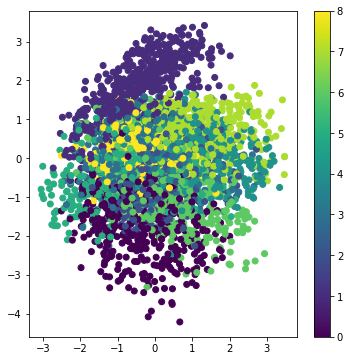

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

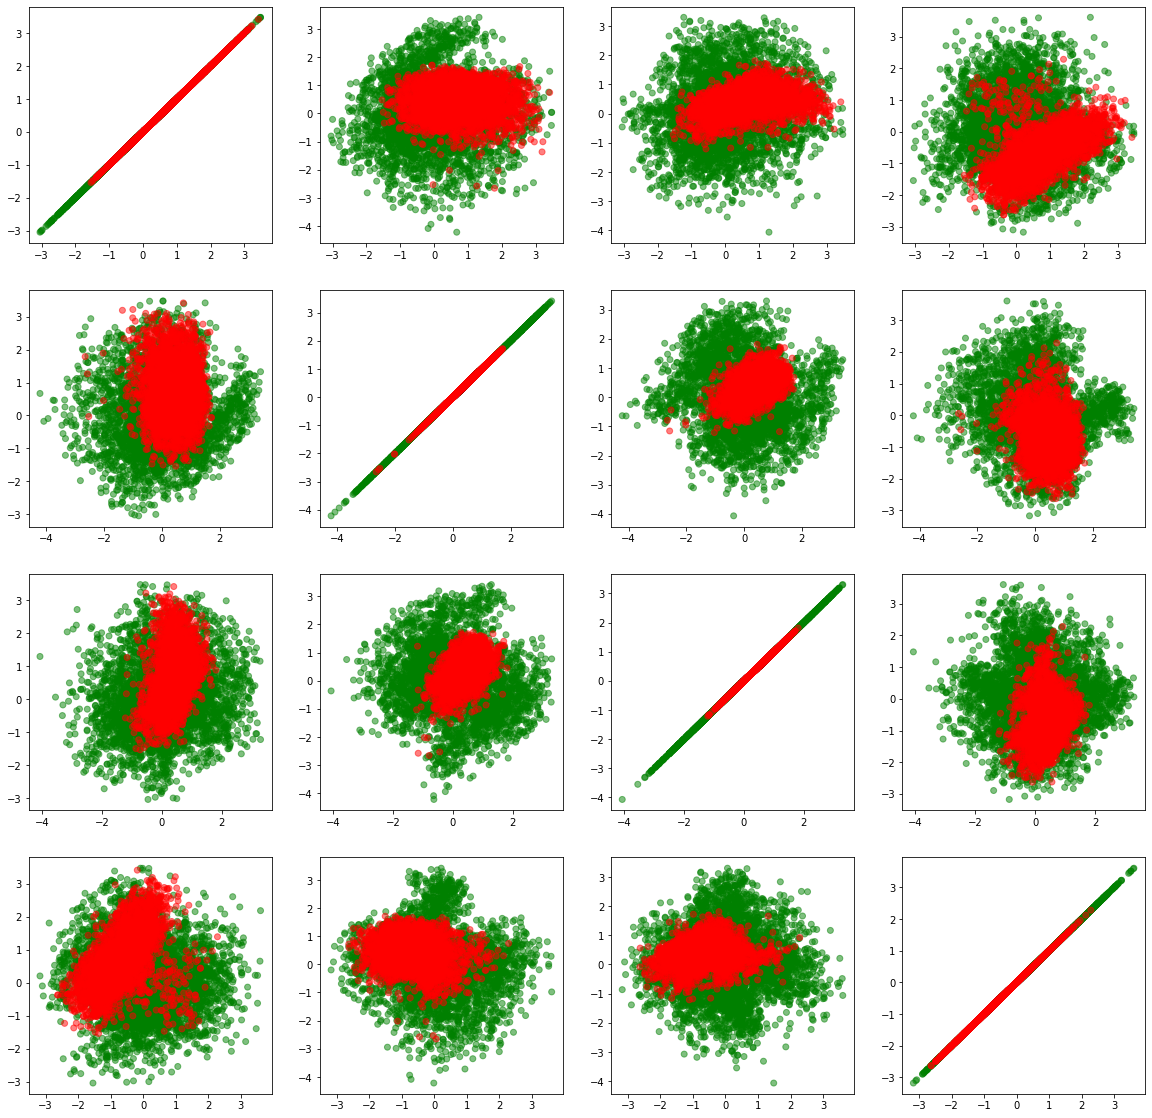

In [13]:
#Plot the 9s and the normal digits

anomaly_encoded = encoder.predict(anomaly_test, batch_size=batch_size)
fig, m_axs = plt.subplots(latent_dim,latent_dim, figsize=(latent_dim*5, latent_dim*5))
if latent_dim == 1:
    m_axs = [[m_axs]]
for i, n_axs in enumerate(m_axs, 0):
    for j, c_ax in enumerate(n_axs, 0):
        c_ax.scatter(np.concatenate([X_test_encoded[:, i], anomaly_encoded[:,i]],0), 
                           np.concatenate([X_test_encoded[:, j], anomaly_encoded[:,j]],0),
            c=(['g']*X_test_encoded.shape[0])+['r']*anomaly_encoded.shape[0], alpha = 0.5)

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8376 samples in 0.006s...
[t-SNE] Computed neighbors for 8376 samples in 0.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8376
[t-SNE] Computed conditional probabilities for sample 2000 / 8376
[t-SNE] Computed conditional probabilities for sample 3000 / 8376
[t-SNE] Computed conditional probabilities for sample 4000 / 8376
[t-SNE] Computed conditional probabilities for sample 5000 / 8376
[t-SNE] Computed conditional probabilities for sample 6000 / 8376
[t-SNE] Computed conditional probabilities for sample 7000 / 8376
[t-SNE] Computed conditional probabilities for sample 8000 / 8376
[t-SNE] Computed conditional probabilities for sample 8376 / 8376
[t-SNE] Mean sigma: 0.215469
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.504890
[t-SNE] KL divergence after 500 iterations: 1.627821


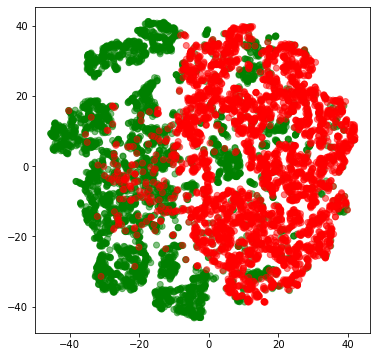

In [14]:
#A TSNe Representation

from sklearn.manifold.t_sne import TSNE
latent_space_tsne = TSNE(2, verbose = True, n_iter = 500)
xa_tsne = latent_space_tsne.fit_transform(np.concatenate([X_test_encoded[:, :], anomaly_encoded[:,:]],0))

plt.figure(figsize=(6, 6))
plt.scatter(xa_tsne[:,0], xa_tsne[:,1],
            c=(['g']*X_test_encoded.shape[0])+['r']*anomaly_encoded.shape[0], alpha = 0.5)
plt.show()

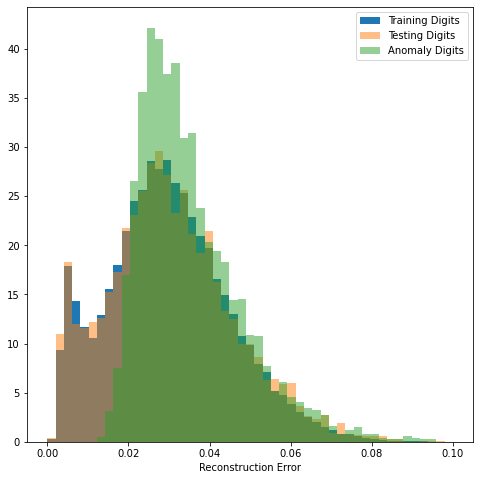

In [15]:
model_mse = lambda x: np.mean(np.square(x-ae.predict(x, batch_size = batch_size)), (1,2,3))
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(X_train), bins = np.linspace(0, .1, 50), label = 'Training Digits', density = True, alpha = 1.0)
ax1.hist(model_mse(X_test), bins = np.linspace(0, .1, 50), label = 'Testing Digits', density = True, alpha = 0.5)
ax1.hist(model_mse(anomaly_test), bins = np.linspace(0, .1, 50), label = 'Anomaly Digits', density = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

Test data score -6.330786925620603
Anomaly score -5.956778867361276


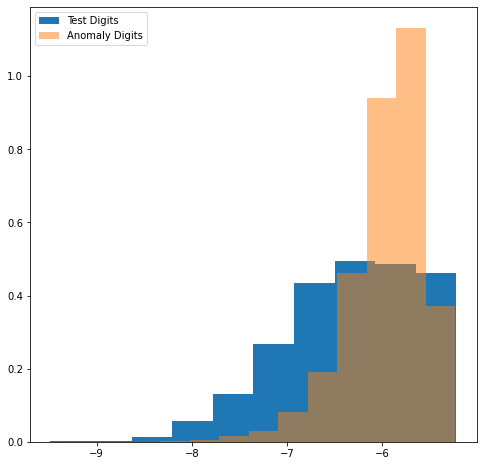

In [16]:
#Fit a PDF to the data
from sklearn.neighbors import KernelDensity
kd = KernelDensity()
kd.fit(encoder.predict(X_train))
test_score = [kd.score(x.reshape(1, -1)) for x in X_test_encoded]
anom_score = [kd.score(x.reshape(1, -1)) for x in anomaly_encoded]
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(test_score, label = 'Test Digits', density = True, alpha = 1.0)
ax1.hist(anom_score, label = 'Anomaly Digits', density = True, alpha = 0.5)
ax1.legend()
print('Test data score', np.mean(test_score))
print('Anomaly score', np.mean(anom_score))

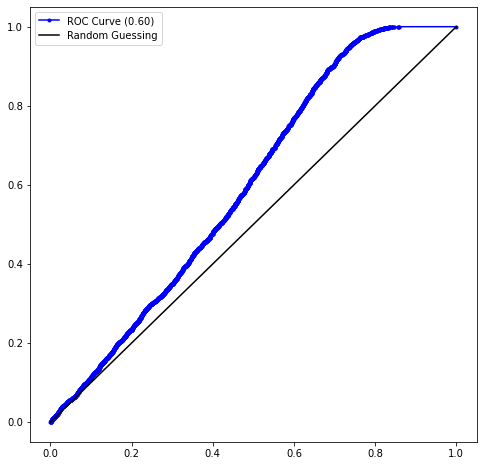

In [17]:
#How well does our detector work?
#We can use an ROC curve to see how meaningful the predictor we have made is for finding outliers compared to normal data
from sklearn.metrics import roc_auc_score, roc_curve
mse_score = np.concatenate([model_mse(X_test), model_mse(anomaly_test)],0)
true_label = [0]*X_test.shape[0]+[1]*anomaly_test.shape[0]
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();

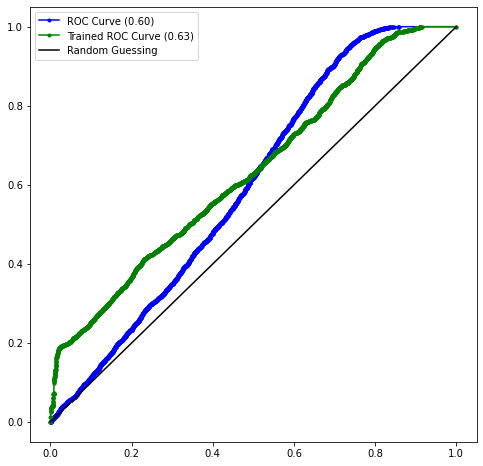

In [18]:
#Improving with 3 training points on TSNE
anom_exam = np.mean(xa_tsne[-3:,:],0)
mse_score_train = np.sqrt(np.square(xa_tsne[:,0]-anom_exam[0])+np.square(xa_tsne[:,1]-anom_exam[1]))
if roc_auc_score(true_label, mse_score_train)<0.5:
    mse_score_train *= -1

fpr_new, tpr_new, thresholds = roc_curve(true_label, mse_score_train)
auc_score_new = roc_auc_score(true_label, mse_score_train)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr_new, tpr_new, 'g.-', label = 'Trained ROC Curve (%2.2f)' %  auc_score_new)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();

In [19]:
#Build a digit generator
decoder_input = Input(shape=(latent_dim,))
_f_decoded = decoder_f(decoder_input)
_h_decoded = decoder_h(_f_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_img = Reshape(original_shape)(_x_decoded_mean)
generator = Model(decoder_input, _x_decoded_img)

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


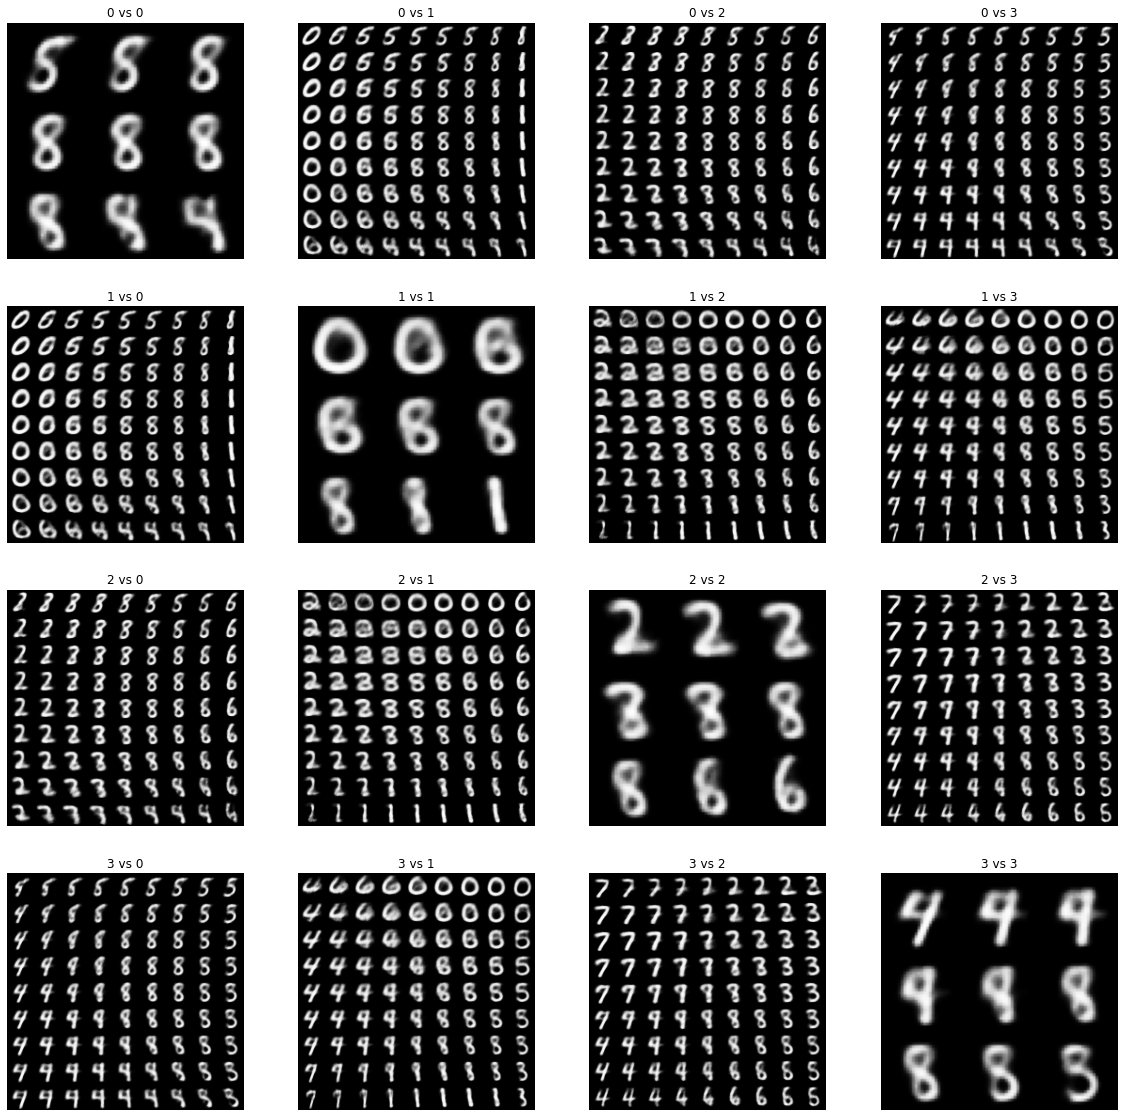

In [20]:
#Display a 2D manifold of the digits
from skimage.util import montage
from itertools import product
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
n = 9
scale_d = norm.ppf(np.linspace(0.05, 0.95, n))

fig, m_axs = plt.subplots(latent_dim,latent_dim, figsize=(latent_dim*5, latent_dim*5))
if latent_dim == 1:
    m_axs = [[m_axs]]
for i, n_axs in enumerate(m_axs, 0):
    for j, c_ax in enumerate(n_axs, 0):
        test_dims = [[0.5]]*latent_dim
        test_dims[i] = scale_d
        test_dims[j] = scale_d
        stack_in = np.stack(product(*test_dims),0)
        stack_out = montage(generator.predict(stack_in)[:,:,:,0])
        c_ax.imshow(stack_out, cmap='Greys_r')
        c_ax.axis('off')
        c_ax.set_title('{} vs {}'.format(i, j))

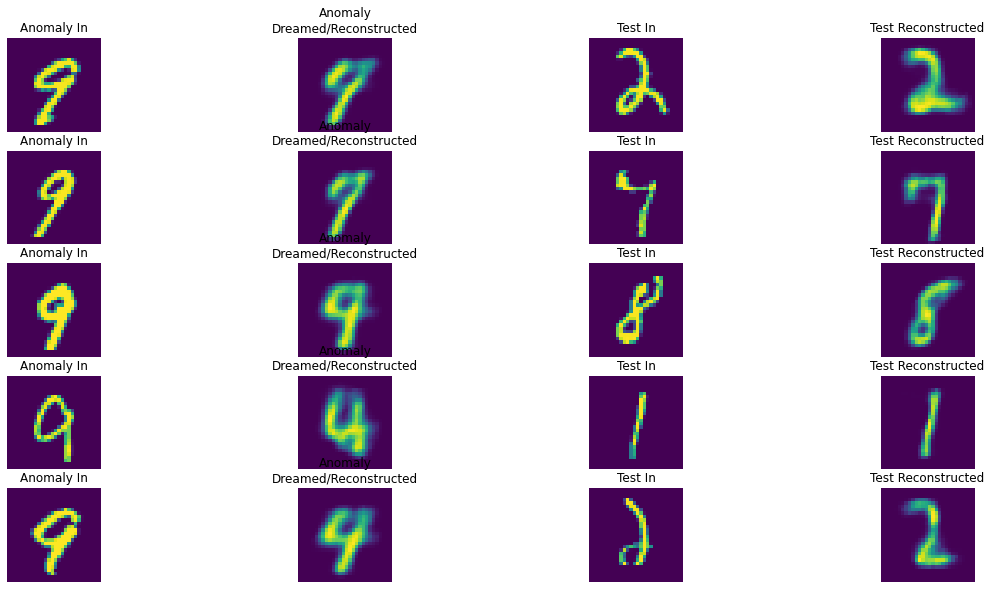

In [21]:
#Display Digits and Reconstruction
fig, m_axs = plt.subplots(5,4, figsize=(20, 10))
[c_ax.axis('off') for c_ax in m_axs.ravel()]
for i, (axa_in, axa_ae, axt_in, axt_ae) in enumerate(m_axs):
    axa_in.imshow(anomaly_test[i,:,:,0])
    axa_in.set_title('Anomaly In')
    axa_ae.imshow(ae.predict(anomaly_test[i:i+1])[0,:,:,0])
    axa_ae.set_title('Anomaly\nDreamed/Reconstructed')
    axt_in.imshow(X_test[i,:,:,0])
    axt_in.set_title('Test In')
    axt_ae.imshow(ae.predict(X_test[i:i+1])[0,:,:,0])
    axt_ae.set_title('Test Reconstructed')

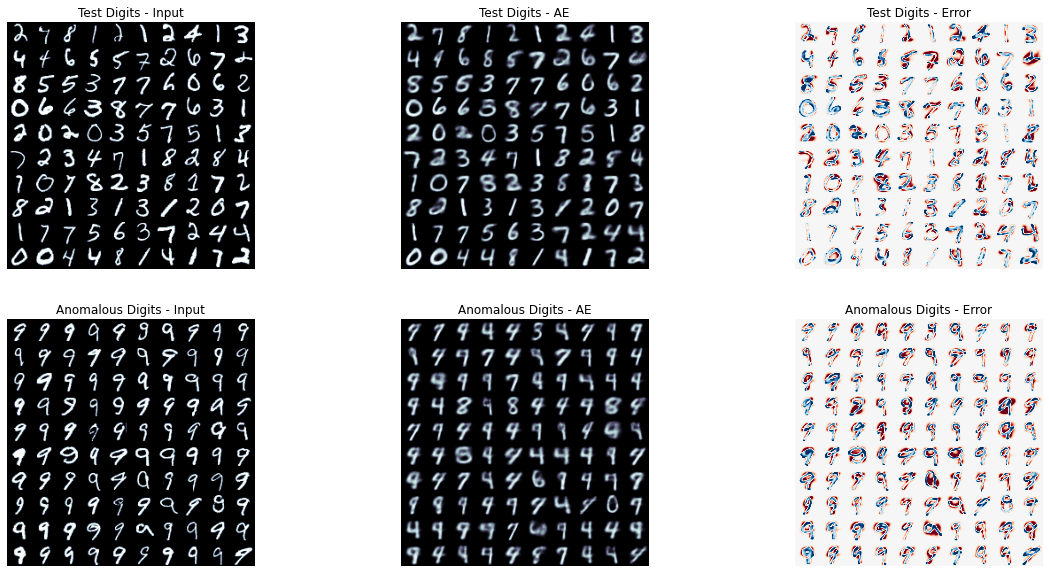

In [22]:
fig, m_axs = plt.subplots(2,3, figsize=(20, 10))
sg_anom = anomaly_test[:100]
sg_test = X_test[:100]
for (ax_tt, ax_an), (c_name, c_func) in zip(m_axs.T, [('Input', lambda x: x), 
                                                   ('AE', ae.predict),
                                                    ('Error', lambda x: x-ae.predict(x))
                                                   ]):
    c_an_dig = c_func(sg_anom)
    if c_an_dig.min()<0:
        plt_kwargs = dict(vmin = -0.5, vmax = 0.5, cmap = 'RdBu')
    else:
        plt_kwargs = dict(cmap = 'bone')
    ax_an.imshow(montage(c_an_dig[:,:,:,0]), **plt_kwargs)
    ax_an.set_title('Anomalous Digits - {}'.format(c_name))
    ax_an.axis('off')
    ax_tt.imshow(montage(c_func(sg_test)[:,:,:,0]), **plt_kwargs)
    ax_tt.set_title('Test Digits - {}'.format(c_name))
    ax_tt.axis('off')

In [29]:
result_labels = result_labels.where(result_labels==9,1)
result_labels = result_labels.where(result_labels==1,0)

In [31]:
result_images.insert(0,'label',result_labels,True)

In [33]:
def clusteredness(df):
    df0 = df[df.label == 0]
    df1 = df[df.label == 1]
    df0 = df0.drop('label',axis='columns')
    df1 = df1.drop('label',axis='columns')

    df0_var = df0.var(1)
    df0_var = df0_var.var(0)
    df1_var = df1.var(1)
    df1_var = df1_var.var(0)

    return df1_var / df0_var

In [34]:
clusterness = clusteredness(result_images)
clusterness

1.6462935841176198